# 1. 全连接卷积神经网络FCN

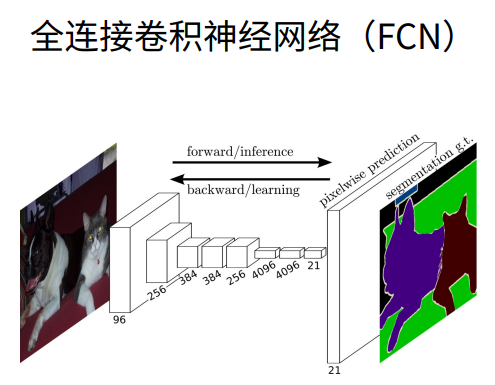

① 1 * 1 卷积层来降低维度。

② 转置卷积层把图片扩大，k是通道有多少类，通道数为类别数，则导致可以对每一个像素分类。

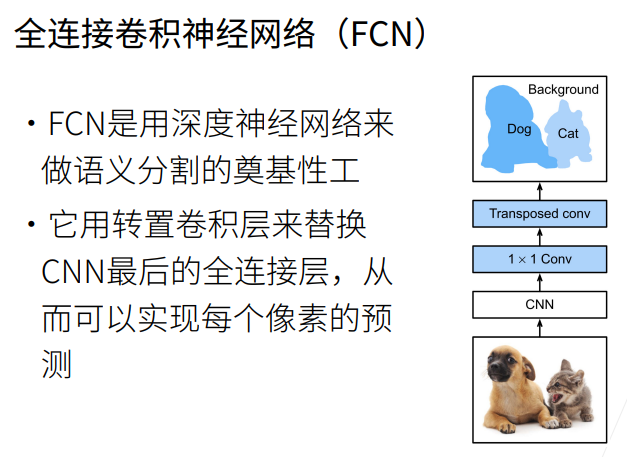

# 2. 全连接卷积神经网络FCN 

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
# 使用在ImageNet数据集上预训练的ResNet18模型来提取图像特征
pretrained_net = torchvision.models.resnet18(pretrained=True)
# 使用list函数和children方法列出预训练模型的所有子层（这些子层通常是神经网络的层）
# 然后使用Python的切片语法来取出最后三层
# 这可以帮助我们理解模型的结构，特别是在我们打算对模型进行微调或者使用模型的某些层来提取特征时
list(pretrained_net.children())[-3:] # 查看最后三层长什么样子

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
# 创建一个全卷积网络实例net
# 使用预训练的ResNet18模型创建一个新的神经网络
# 其中，"*list(pretrained_net.children())[:-2]"这段代码将ResNet18模型的所有子层（除了最后两层）作为新网络的层    
# 这样，新网络实际上是ResNet18模型去掉最后两层后的版本
# 这种方法常常用于迁移学习，即利用一个在大型数据集上训练过的模型的特征提取部分，来帮助我们处理新的任务
net = nn.Sequential(*list(pretrained_net.children())[:-2]) # 去掉ResNet18最后两层
# 创建一个形状为(1, 3, 320, 480)的随机张量，这可以看作是一张形状为(320, 480)，有三个颜色通道的图片
# 这里的3代表图片的颜色通道数量（红、绿、蓝），320和480分别代表图片的高度和宽度
# 随机张量的所有元素都是在[0, 1)之间随机生成的，可以看作是随机图片的像素值
X = torch.rand(size=(1,3,320,480)) # 卷积核与输入大小无关，全连接层与输入大小有关
# 将随机生成的图片输入到网络中，通过调用net(X)，进行前向传播
# 打印输出张量的形状，输出的形状通常可以用于检查网络的结构是否正确
# 对于全卷积网络，输出的宽度和高度通常会比输入的小，这是由于卷积和池化操作造成的
# 在这个例子中，输出的宽度和高度应该是输入的1/32，这是由ResNet18的结构决定的
net(X).shape  # 缩小32倍

torch.Size([1, 512, 10, 15])

In [4]:
# 使用1X1卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）
# 将要素地图的高度和宽度增加32倍
# 定义目标数据集中的类别数量，这里的21表示Pascal VOC2012数据集中有21个类别，包括20个物体类别和一个背景类别
num_classes = 21
# 在网络末尾添加一个新的卷积层，这是一个1x1的卷积层，输入通道数为512（这是由前面的ResNet18模型决定的）
# 输出通道数为我们定义的类别数量，即21
# 1x1卷积层常用于改变通道数，即可以将前一层的特征图投影到一个新的空间，这个新的空间的维度即为卷积层的输出通道数
net.add_module('final_conv',nn.Conv2d(512,num_classes,kernel_size=1))  
# 图片放大32倍，所以stride为32
# padding根据kernel要保证高宽不变的最小值，16 * 2 = 32，图片左右各padding
# kernel为64，原本取图片32大小的一半，再加上padding的32，就相当于整个图片
# 再添加一个转置卷积层，转置卷积也被称为反卷积，通常用于将小尺寸的特征图放大到原来的大小
# 这里的输入和输出通道数都是num_classes，表示我们希望在放大的过程中保持通道数不变
# kernel_size是64，stride是32，这意味着这一层将特征图的宽度和高度放大了32倍
# padding是16，它用于在特征图的边缘添加额外的区域，使得输出的大小正好是输入的32倍
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes,num_classes,kernel_size=64,padding=16,stride=32)) 

In [5]:
# 初始化转置卷积层

# 双线性插值核的实现
# 定义一个函数，用于初始化双线性插值核
# 这个函数接受三个参数：输入通道数、输出通道数和核大小
def bilinear_kernel(in_channels, out_channels, kernel_size):
    # 计算双线性插值核中心点位置
    # 计算双线性插值核的尺寸的一半，由于我们希望中心点位于核的中心，所以需要先计算核的一半大小
    # 我们使用 // 运算符进行整数除法，确保结果为整数
    factor = (kernel_size + 1) // 2
    # 根据核的大小是奇数还是偶数，确定中心点的位置
    # 如果核的大小是奇数，则中心点位于尺寸的一半减去1的位置，因为Python的索引从0开始，所以减去1
    # 例如，如果核的大小是3，那么中心点应该位于1的位置，(3+1)//2 - 1 = 1
    if kernel_size % 2 == 1:
        center = factor - 1
    # 如果核的大小是偶数，则中心点位于尺寸的一半减去0.5的位置
    # 这是因为偶数大小的核没有明确的中心点，所以我们取中间两个元素的平均位置作为中心点
    # 例如，如果核的大小是4，那么中心点应该位于1.5的位置，(4+1)//2 - 0.5 = 1.5
    else:
        center = factor - 0.5
    # 创建一个矩阵，其元素的值等于其与中心点的距离
    og = (torch.arange(kernel_size).reshape(-1,1),
         torch.arange(kernel_size).reshape(1,-1))
    # 计算双线性插值核，其值由中心点出发，向外线性衰减
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)    
    # 初始化一个权重矩阵，大小为 (输入通道数, 输出通道数, 核大小, 核大小)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))  
    # 将双线性插值核的值赋给对应位置的权重
    weight[range(in_channels),range(out_channels),:,:] = filt
    # 返回初始化的权重矩阵，这个权重矩阵可以直接用于初始化转置卷积层的权重
    return weight

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


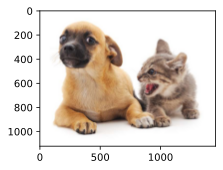

In [6]:
# 双线性插值的上采样实验
# 创建一个转置卷积层，输入和输出通道数都是3，这是因为我们处理的是RGB图片，每个颜色通道都需要进行处理
# 核大小是4，步长是2，这意味着这个层将输入的宽度和高度放大了2倍
# 设置bias为False，因为我们不需要偏置项
conv_trans = nn.ConvTranspose2d(3,3,kernel_size=4,padding=1,stride=2,bias=False)  
# 使用双线性插值核初始化转置卷积层的权重
# 这里我们使用了copy_方法，这是一种就地操作，直接修改了原始张量的值
conv_trans.weight.data.copy_(bilinear_kernel(3,3,4)) # 双线性核初始化权重
# 使用torchvision.transforms.ToTensor()将一张JPEG格式的图片转换为张量
img = torchvision.transforms.ToTensor()(d2l.Image.open('01_Data/03_catdog.jpg'))
# 增加一个批次维度
X = img.unsqueeze(0)
# 将图片张量输入到转置卷积层中，得到上采样的结果
Y = conv_trans(X)
# 将输出结果转换为可以展示的格式，即(高度, 宽度, 颜色通道)的格式，并从计算图中分离出来，这样就可以转换为NumPy数组
out_img = Y[0].permute(1,2,0).detach()
# 设置展示图片的大小
d2l.set_figsize()
# 打印输入图片的形状
print('input image shape:', img.permute(1,2,0).shape)
# 展示图片
d2l.plt.imshow(img.permute(1,2,0))
# 打印输出图片的形状并展示图片
# 可以看到，输出图片的宽度和高度都是输入的2倍，这正是我们设置的步长
print('output image shape:',out_img.shape) # 输出被拉大了2倍
# 并展示图片
d2l.plt.imshow(out_img)

In [7]:
# 用双线性插值的上采样初始化转置卷积层
# 对于1X1卷积层，我们使用Xavier初始化参数
# 使用双线性插值核初始化转置卷积层的权重
# num_classes是目标数据集中的类别数量，这里使用双线性插值核的尺寸为64
W = bilinear_kernel(num_classes, num_classes, 64)
# 将初始化的权重W复制给转置卷积层的权重
# 使用copy_方法进行就地操作，直接修改原始张量的值
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [8]:
# 读取数据集
# 设置批处理大小和图像裁剪大小
# 批处理大小 (batch_size) 是一次训练迭代中同时处理的样本数量，这个参数影响模型训练的速度和效果
# 裁剪大小 (crop_size) 是输入模型的图像尺寸，需要和模型的输入层尺寸匹配，不同的模型可能需要不同尺寸的输入
batch_size, crop_size = 32, (320,480)
# 使用 d2l.load_data_voc 函数读取VOC2012数据集
# 此函数将会返回训练和测试的数据迭代器，数据迭代器可以按批次产生数据，方便训练模型
# 在读取数据的过程中，图像会被裁剪到设定的尺寸，并且会进行一些常规的数据增强操作，如随机裁剪、随机翻转等
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.413, train acc 0.870, test acc 0.853
89.1 examples/sec on [device(type='cuda', index=0)]


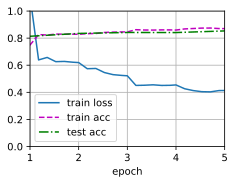

In [9]:
# 训练
# 定义损失函数，这里使用交叉熵损失
# inputs 是网络的预测输出，targets 是真实标签
# 交叉熵损失会对每个像素的预测结果进行评估，然后计算平均损失
# 使用reduction='none'选项禁止了损失的自动平均或求和，所以我们需要手动计算均值
def loss(inputs, targets):
    # 原先是对一个label做预测，算出一个值，现在是对图片里所有的label做预测，所有的像素都有值，loss为一个矩阵  
    # .mean(1).mean(1) 使得高做一下均值，对宽做一下均值，每个图片获得一个loss值
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)    

# 设置训练参数：训练轮次(num_epochs)、学习率(lr)、权重衰减(wd)和设备(devices)
# 这里使用了所有可用的GPU进行训练，如果没有可用的GPU，将使用CPU
num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
# 初始化优化器，这里使用随机梯度下降（SGD）优化器
# 优化器会更新模型的参数以最小化损失函数
# 参数lr是学习率，权重衰减(wd)有助于防止模型过拟合
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
# 调用d2l.train_ch13函数进行训练
# 这个函数会在每个训练轮次中遍历训练数据，然后在测试数据上评估模型的性能
# 损失函数和优化器用于指导模型的训练
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)   

In [10]:
# 预测
# 定义预测函数，输入参数img是待预测的图像
def predict(img):
    # 首先，对图像进行归一化处理，并添加一个批量维度，以匹配模型的输入需求
    # normalize_image函数会对图像的每个像素进行归一化处理，使其值在0到1之间
    # unsqueeze(0)是在第一个维度（批量维度）添加一个新的维度
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    # 之后，将预处理后的图像输入到模型中进行预测
    # 将图像数据移动到设备（如GPU）上
    # 使用argmax(dim=1)找出预测结果中概率最大的类别，返回这个类别的索引
    pred = net(X.to(devices[0])).argmax(dim=1) # 通道维度做argmax，因此得到每一个像素预测的标号  
    # 最后，将预测结果的形状改变成与原始图像相同的形状
    # 通过reshape函数将预测结果的形状改为(高度,宽度)，这样每个像素都有一个对应的类别标签
    return pred.reshape(pred.shape[1],pred.shape[2]) # 跟图片高宽等同的一个矩阵  

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

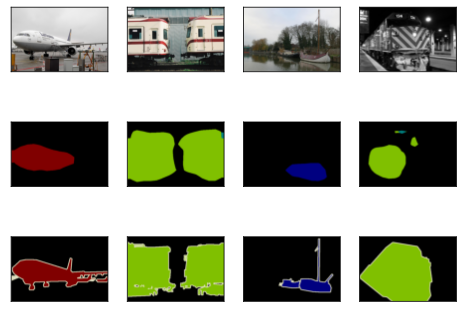

In [11]:
# 可视化预测的类别
# 定义一个函数将预测的类别转换为图像
def label2image(pred):
    # 使用VOC_COLORMAP将类别转换为RGB颜色
    # VOC_COLORMAP是一个列表，其中包含21种不同的RGB颜色，每种颜色对应一个物体类别
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])# 把类别的RGB值做成一个tensor
    # 将预测的结果转换为long型以对应颜色映射的索引
    X = pred.long() # 把预测值做成一个index
    # 根据类别索引找到对应的颜色
    return colormap[X,:] # 把预测的RGB值画出来
# 下载并解压VOC2012数据集
voc_dir = d2l.download_extract('voc2012','VOCdevkit/VOC2012')
# 读取VOC2012数据集的测试图像和标签
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
# n设定为4，表示要处理4个图像。imgs：这是一个空的列表，它将被用来存储图像。
n, imgs = 4, []
# 循环预测4个测试样本并将预测结果转换为图像
for i in range(n):
    # 设置裁剪的区域
    crop_rect = (0,0,320,480)
    # 对图像进行裁剪
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)  
    # 预测裁剪后的图像，并将预测结果转换为图像
    pred = label2image(predict(X)) # 预测转成图片
    # 将原图，预测的图像和标签图像加入到imgs列表中
    imgs += [X.permute(1,2,0), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i],*crop_rect).permute(1,2,0)]
# 显示原图、预测的图像和标签图像    
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3],3,n,scale=2) # 第二行为预测，第三行为真实标号